<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/Color_error_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Google drive loading  and function imports**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
import contextlib

# Suppress output
with contextlib.redirect_stdout(None):
    os.system('ls drive/My\\ Drive')

file_path = "/content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/"

Mounted at /content/drive


# **1. Test models on selected patches**

## RGB model

In [11]:
import os
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

# -------- CONFIGURATION -------- #
input_folder = "deltaE/[24-Before-Test]"
output_folder = "deltaE/[24-RGB]"
model_path = "Model/24/unet_rgb.keras"
n_size = 8
# -------------------------------- #

# Ensure output folder exists
os.makedirs(os.path.join(file_path, output_folder), exist_ok=True)

def crop_(im):
    width, height = im.size
    data = []
    for j in np.arange(0, int(height / n_size), 0.5):
        for i in range(0, int(width / n_size)):
            im1 = im.crop((0 + (n_size * i), 0 + (n_size * j), n_size + (n_size * i), n_size + (n_size * j)))
            im1 = np.array(im1).astype(np.float32)
            data.append(im1)
    return data

# Load model
autoencoder = keras.models.load_model(os.path.join(file_path, model_path))

# Process each image
for filename in os.listdir(os.path.join(file_path, input_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        painting_name = os.path.splitext(filename)[0]
        image_path = os.path.join(file_path, input_folder, filename)
        print(f"Processing: {painting_name}")

        test = Image.open(image_path).convert('RGB')
        test = ImageOps.expand(test, border=2, fill='black')
        w_dirty, h_dirty = test.size



        xx = int(w_dirty / n_size)
        final = []

        for portion in np.arange(0, xx, 0.5):
            im1 = test.crop((n_size * portion, 0, (n_size * portion) + n_size, h_dirty))
            w1, h1 = im1.size
            neverbeforeseen = np.array(crop_(im1))
            neverbeforeseen = neverbeforeseen[:, :, :, 0:3]
            neverbeforeseen = np.array(neverbeforeseen).astype(np.float32) / 255.0

            decoded_imgs = autoencoder.predict(neverbeforeseen, verbose=0)
            decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
            col = np.vstack(decoded_imgs)
            y = (col * 255).astype('uint8')

            if portion == 0:
                final = y
            else:
                final = np.hstack((final, y))

        if w_dirty == 40:
          final = final[:36, :36, :]
        reconstructed = Image.fromarray(np.squeeze(final))
        output_path = os.path.join(file_path, output_folder, f"{painting_name}.png")
        reconstructed.save(output_path)
        print(f"Saved to: {output_path}")


Processing: 6
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-RGB]/6.png
Processing: 1_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-RGB]/1_.png
Processing: 2_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-RGB]/2_.png
Processing: 3_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-RGB]/3_.png
Processing: 4_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-RGB]/4_.png
Processing: 5_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-RGB]/5_.png


## LAB model

In [12]:
import os
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

# -------- CONFIGURATION -------- #
input_folder = "deltaE/[24-Before-Test]"
output_folder = "deltaE/[24-LAB]"
model_path = "Model/24/unet_lab.keras"
n_size = 8
# -------------------------------- #

# Ensure output folder exists
os.makedirs(os.path.join(file_path, output_folder), exist_ok=True)

# ------------ FUNCTIONS ------------ #
def rgb_lab_normalized(rgb_image):
    rgb_array = np.array(rgb_image) / 255.0
    lab_array = color.rgb2lab(rgb_array)
    lab_array[..., 0] = lab_array[..., 0] / 100.0
    lab_array[..., 1] = (lab_array[..., 1] + 128) / 255.0
    lab_array[..., 2] = (lab_array[..., 2] + 128) / 255.0
    return Image.fromarray((lab_array * 255).astype(np.uint8))

def lab_rgb_unnormalized(lab_image):
    lab_array = np.array(lab_image / 255.0)
    lab_array[..., 0] = lab_array[..., 0] * 100.0
    lab_array[..., 1] = (lab_array[..., 1] * 255.0) - 128
    lab_array[..., 2] = (lab_array[..., 2] * 255.0) - 128
    rgb_array = color.lab2rgb(lab_array)
    rgb_array = (rgb_array * 255).astype(np.uint8)
    return Image.fromarray(rgb_array, mode='RGB')

def crop_(im):
    width, height = im.size
    data = []
    for j in np.arange(0, int(height / n_size), 0.5):
        for i in range(0, int(width / n_size)):
            im1 = im.crop((n_size * i, n_size * j, n_size * (i + 1), n_size * (j + 1)))
            im1 = np.array(im1).astype(np.float32)
            data.append(im1)
    return data

# Load model
autoencoder = keras.models.load_model(os.path.join(file_path, model_path))

# Process each image
for filename in os.listdir(os.path.join(file_path, input_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        painting_name = os.path.splitext(filename)[0]
        image_path = os.path.join(file_path, input_folder, filename)
        print(f"Processing: {painting_name}")

        test = Image.open(image_path).convert('RGB')
        test = rgb_lab_normalized(test)
        test = ImageOps.expand(test, border=2, fill='black')
        w_dirty, h_dirty = test.size

        xx = int(w_dirty / n_size)
        final = []

        for portion in np.arange(0, xx, 0.5):
            im1 = test.crop((n_size * portion, 0, (n_size * portion) + n_size, h_dirty))
            neverbeforeseen = np.array(crop_(im1))
            neverbeforeseen = neverbeforeseen[:, :, :, 0:3]
            neverbeforeseen = neverbeforeseen.astype(np.float32) / 255.0

            decoded_imgs = autoencoder.predict(neverbeforeseen, verbose=0)
            decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
            col = np.vstack(decoded_imgs)
            y = (col * 255).astype('uint8')

            final = y if portion == 0 else np.hstack((final, y))
        if w_dirty == 40:
          final = final[:36, :36, :]
        final_lab = lab_rgb_unnormalized(final)
        output_path = os.path.join(file_path, output_folder, f"{painting_name}.png")
        final_lab.save(output_path)
        print(f"Saved to: {output_path}")


Processing: 6
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-LAB]/6.png
Processing: 1_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-LAB]/1_.png
Processing: 2_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-LAB]/2_.png
Processing: 3_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-LAB]/3_.png
Processing: 4_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-LAB]/4_.png
Processing: 5_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-LAB]/5_.png


## L_ab model

In [13]:
import os
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

# -------- CONFIGURATION -------- #
input_folder = "deltaE/[24-Before-Test]"
output_folder = "deltaE/[24-L_AB]"
model_L_path = "Model/24/unet_L.keras"
model_AB_path = "Model/24/unet_ab.keras"
n_size = 8
# -------------------------------- #

os.makedirs(os.path.join(file_path, output_folder), exist_ok=True)

# ------------ FUNCTIONS ------------ #
def rgb_lab_normalized(im):
    rgb_array = np.array(im) / 255.0
    lab_array = color.rgb2lab(rgb_array)
    lab_array[..., 0] /= 100.0
    lab_array[..., 1] = (lab_array[..., 1] + 128) / 255.0
    lab_array[..., 2] = (lab_array[..., 2] + 128) / 255.0
    return Image.fromarray((lab_array * 255).astype(np.uint8), mode='LAB')

def L_AB_rgb_unnormalized(ab_image, final_L):
    ab_image = ab_image / 255.0
    final_L = final_L / 255.0
    final_L[..., 0] *= 100.0
    ab_image[..., 0] = (ab_image[..., 0] * 255.0) - 128
    ab_image[..., 1] = (ab_image[..., 1] * 255.0) - 128
    LAB_array = np.dstack((final_L, ab_image[:, :, 0], ab_image[:, :, 1]))
    rgb_array = color.lab2rgb(LAB_array)
    rgb_array = (rgb_array * 255).astype(np.uint8)
    return Image.fromarray(rgb_array, mode='RGB')

def crop_(im):
    width, height = im.size
    data = []
    for j in np.arange(0, int(height / n_size), 0.5):
        for i in range(0, int(width / n_size)):
            im1 = im.crop((n_size * i, n_size * j, n_size * (i + 1), n_size * (j + 1)))
            im1 = np.array(im1).astype(np.float32)
            data.append(im1)
    return data

# Load models
model_L = keras.models.load_model(os.path.join(file_path, model_L_path))
model_AB = keras.models.load_model(os.path.join(file_path, model_AB_path))

# Process each image
for filename in os.listdir(os.path.join(file_path, input_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        painting_name = os.path.splitext(filename)[0]
        image_path = os.path.join(file_path, input_folder, filename)
        print(f"Processing: {painting_name}")

        # Read and convert to LAB-normalized
        test = Image.open(image_path).convert('RGB')
        test = rgb_lab_normalized(test)
        test = ImageOps.expand(test, border=2, fill='black')
        w_dirty, h_dirty = test.size

        xx = int(w_dirty / n_size)

        # --------- Predict L ---------
        final_L = []
        for portion in np.arange(0, xx, 0.5):
            im1 = test.crop((n_size * portion, 0, (n_size * portion) + n_size, h_dirty))
            neverbeforeseen = np.array(crop_(im1))[:, :, :, 0:1]
            neverbeforeseen = neverbeforeseen.astype(np.float32) / 255.0
            decoded_imgs = model_L.predict(neverbeforeseen, verbose=0)
            decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
            col = np.vstack(decoded_imgs)
            y = (col * 255).astype('uint8')
            final_L = y if portion == 0 else np.hstack((final_L, y))

        # --------- Predict AB ---------
        final_AB = []
        for portion in np.arange(0, xx, 0.5):
            im1 = test.crop((n_size * portion, 0, (n_size * portion) + n_size, h_dirty))
            neverbeforeseen = np.array(crop_(im1))[:, :, :, 1:3]
            neverbeforeseen = neverbeforeseen.astype(np.float32) / 255.0
            decoded_imgs = model_AB.predict(neverbeforeseen, verbose=0)
            decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
            col = np.vstack(decoded_imgs)
            y = (col * 255).astype('uint8')
            final_AB = y if portion == 0 else np.hstack((final_AB, y))

        if w_dirty == 40:
          final_L = final_L[:36, :36, :]
          final_AB = final_AB[:36, :36, :]
        # Combine L and AB predictions
        reconstructed = L_AB_rgb_unnormalized(final_AB, final_L)
        output_path = os.path.join(file_path, output_folder, f"{painting_name}.png")
        reconstructed.save(output_path)
        print(f"Saved to: {output_path}")


Processing: 6
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-L_AB]/6.png
Processing: 1_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-L_AB]/1_.png
Processing: 2_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-L_AB]/2_.png
Processing: 3_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-L_AB]/3_.png
Processing: 4_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-L_AB]/4_.png
Processing: 5_
Saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-L_AB]/5_.png


# **2. Delta E function**

In [14]:
import numpy as np
import cv2
from skimage import io

def delta_e_cie2000(lab1, lab2):
    # Constants
    kL = 1
    kC = 1
    kH = 1

    L1, a1, b1 = lab1
    L2, a2, b2 = lab2

    # CIE 2000 formula
    L_bar_prime = 0.5 * (L1 + L2)
    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    C_bar = 0.5 * (C1 + C2)
    C_bar7 = C_bar**7

    G = 0.5 * (1 - np.sqrt(C_bar7 / (C_bar7 + 25**7)))
    a1_prime = (1 + G) * a1
    a2_prime = (1 + G) * a2

    C1_prime = np.sqrt(a1_prime**2 + b1**2)
    C2_prime = np.sqrt(a2_prime**2 + b2**2)
    C_bar_prime = 0.5 * (C1_prime + C2_prime)

    h1_prime = np.degrees(np.arctan2(b1, a1_prime)) % 360
    h2_prime = np.degrees(np.arctan2(b2, a2_prime)) % 360

    H_bar_prime = h1_prime + h2_prime
    if abs(h1_prime - h2_prime) > 180:
        H_bar_prime += 360
    H_bar_prime *= 0.5

    T = 1 - 0.17 * np.cos(np.radians(H_bar_prime - 30)) \
        + 0.24 * np.cos(np.radians(2 * H_bar_prime)) \
        + 0.32 * np.cos(np.radians(3 * H_bar_prime + 6)) \
        - 0.20 * np.cos(np.radians(4 * H_bar_prime - 63))

    delta_h_prime = h2_prime - h1_prime
    if abs(delta_h_prime) > 180:
        if h2_prime <= h1_prime:
            delta_h_prime += 360
        else:
            delta_h_prime -= 360

    delta_L_prime = L2 - L1
    delta_C_prime = C2_prime - C1_prime
    delta_H_prime = 2 * np.sqrt(C1_prime * C2_prime) * np.sin(np.radians(delta_h_prime * 0.5))

    S_L = 1 + ((0.015 * (L_bar_prime - 50) ** 2) / np.sqrt(20 + (L_bar_prime - 50) ** 2))
    S_C = 1 + 0.045 * C_bar_prime
    S_H = 1 + 0.015 * C_bar_prime * T

    delta_theta = 30 * np.exp(-(((H_bar_prime - 275) / 25) ** 2))
    R_C = 2 * np.sqrt(C_bar7 / (C_bar7 + 25**7))
    R_T = -R_C * np.sin(2 * np.radians(delta_theta))

    delta_E = np.sqrt(
        (delta_L_prime / (kL * S_L)) ** 2 +
        (delta_C_prime / (kC * S_C)) ** 2 +
        (delta_H_prime / (kH * S_H)) ** 2 +
        R_T * (delta_C_prime / (kC * S_C)) * (delta_H_prime / (kH * S_H))
    )

    return delta_E


def color_error(image1_path,image2_path):
    image1 = io.imread(image1_path)
    image2 = io.imread(image2_path)
    # Ensure images are in uint8 format
    if image1.dtype != np.uint8:
        image1 = (image1 * 255).astype(np.uint8)
    if image2.dtype != np.uint8:
        image2 = (image2 * 255).astype(np.uint8)
    # Remove the alpha channel if it exists
    if image1.shape[-1] == 4:
        image1 = image1[..., :3]
    if image2.shape[-1] == 4:
        image2 = image2[..., :3]
    # Ensure the images have the same dimensions

    # Remove 2-pixel border from all sides
    image1 = image1[2:-2, 2:-2]
    image2 = image2[2:-2, 2:-2]

    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")
    # Convert images to LAB color space
    image1_lab = cv2.cvtColor(image1, cv2.COLOR_RGB2LAB)
    image2_lab = cv2.cvtColor(image2, cv2.COLOR_RGB2LAB)

    # Scale LAB values to match theoretical ranges
    image1_lab = np.copy(image1_lab).astype(np.float64)
    image2_lab = np.copy(image2_lab).astype(np.float64)

    image1_lab[:, :, 0] = image1_lab[:, :, 0] * (100 / 255)  # L channel
    image1_lab[:, :, 1] = image1_lab[:, :, 1] - 128          # a channel
    image1_lab[:, :, 2] = image1_lab[:, :, 2] - 128          # b channel

    image2_lab[:, :, 0] = image2_lab[:, :, 0] * (100 / 255)  # L channel
    image2_lab[:, :, 1] = image2_lab[:, :, 1] - 128          # a channel
    image2_lab[:, :, 2] = image2_lab[:, :, 2] - 128          # b channel

    # Flatten the images for easier processing
    image1_lab_flat = image1_lab.reshape((-1, 3))
    image2_lab_flat = image2_lab.reshape((-1, 3))

    # Compute Delta E 2000 for each pair of pixels
    delta_e_values = np.array([delta_e_cie2000(lab1, lab2) for lab1, lab2 in zip(image1_lab_flat, image2_lab_flat)])
    delta_e_values_mean = np.mean(delta_e_values)
    # Reshape the delta_e_values to match the image dimensions, if u wanna plot
    #delta_e_image = delta_e_values.reshape(image1_lab.shape[:2])
    return delta_e_values_mean

# **Compute delta E**

In [15]:
import os
import csv
import numpy as np
from skimage import io

lab_folder = file_path + "deltaE/[24-L_AB]"
after_test_folder = file_path + "deltaE/[24-After-Test]"

# Get all image filenames in [24-RGB]
lab_images = sorted([f for f in os.listdir(lab_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])

results = []
all_delta_e_values = []

for filename in lab_images:
    lab_path = os.path.join(lab_folder, filename)
    test_path = os.path.join(after_test_folder, filename)

    if os.path.exists(test_path):
        try:
            # Load and preprocess the images
            image1 = io.imread(lab_path)
            image2 = io.imread(test_path)

            if image1.dtype != np.uint8:
                image1 = (image1 * 255).astype(np.uint8)
            if image2.dtype != np.uint8:
                image2 = (image2 * 255).astype(np.uint8)

            if image1.shape[-1] == 4:
                image1 = image1[..., :3]
            if image2.shape[-1] == 4:
                image2 = image2[..., :3]

            image1 = image1[2:-2, 2:-2]
            image2 = image2[2:-2, 2:-2]

            if image1.shape != image2.shape:
                raise ValueError("Mismatched image sizes")

            # Convert to LAB
            image1_lab = cv2.cvtColor(image1, cv2.COLOR_RGB2LAB).astype(np.float64)
            image2_lab = cv2.cvtColor(image2, cv2.COLOR_RGB2LAB).astype(np.float64)

            image1_lab[..., 0] *= 100 / 255
            image1_lab[..., 1:] -= 128

            image2_lab[..., 0] *= 100 / 255
            image2_lab[..., 1:] -= 128

            image1_flat = image1_lab.reshape((-1, 3))
            image2_flat = image2_lab.reshape((-1, 3))

            delta_e_values = np.array([delta_e_cie2000(l1, l2) for l1, l2 in zip(image1_flat, image2_flat)])

            # Save per-image result (mean + std)
            mean_error = np.mean(delta_e_values)
            std_error = np.std(delta_e_values)
            results.append((filename, mean_error, std_error))

            # Save all ΔE values for global stats
            all_delta_e_values.extend(delta_e_values)

        except Exception as e:
            print(f"Error processing {filename}: {e}")
    else:
        print(f"Missing match for {filename} in {after_test_folder}")


# Compute global stats
all_delta_e_values = np.array(all_delta_e_values)
global_mean = np.mean(all_delta_e_values)
global_std = np.std(all_delta_e_values)


print("\n--- Global Stats ---")
print(f"Global ΔE00 Mean: {global_mean:.4f}")
print(f"Global ΔE00 Std Dev: {global_std:.4f}")

# Append the global row
results.append(("global", global_mean, global_std))

# Save to CSV
csv_path = os.path.join(lab_folder, "color_error_report.csv")

with open(csv_path, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["image", "mean", "std"])
    for row in results:
        writer.writerow([row[0], f"{row[1]:.4f}", f"{row[2]:.4f}"])

print(f"\nCSV saved to: {csv_path}")



--- Global Stats ---
Global ΔE00 Mean: 3.2044
Global ΔE00 Std Dev: 1.7862

CSV saved to: /content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/deltaE/[24-L_AB]/color_error_report.csv


# Visualize delta E on patches

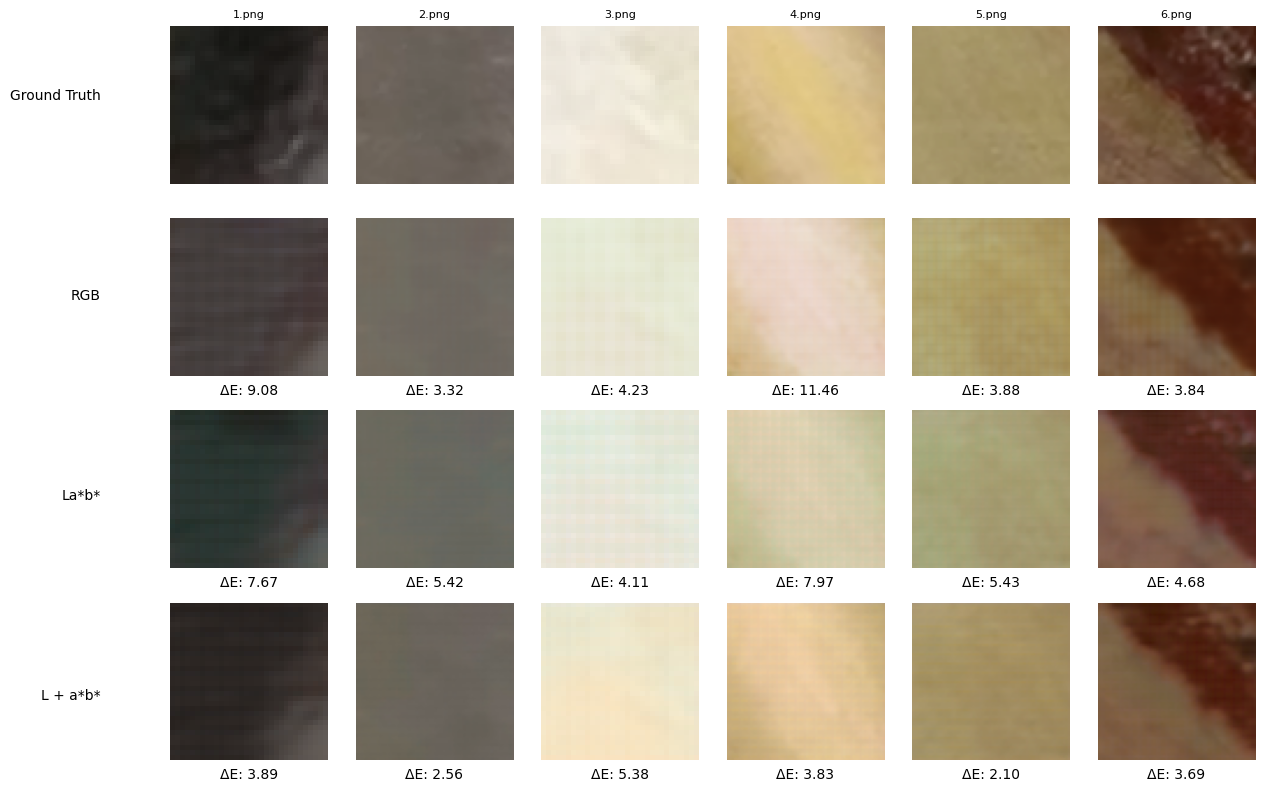

In [22]:
import matplotlib.pyplot as plt

# Define all model folders
model_folders = [
    ("RGB", file_path + "deltaE/[24-RGB]"),       # Replace with actual model 1 folder
    ("La*b*", file_path + "deltaE/[24-LAB]"),     # Replace with actual model 2 folder
    ("L + a*b*", file_path + "deltaE/[24-L_AB]")      # Replace with actual model 3 folder
]
ground_truth_folder = file_path + "deltaE/[24-After-Test]"

image_filenames = sorted([
    f for f in os.listdir(model_folders[0][1])
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))
])

num_models = len(model_folders)
num_rows = num_models + 1
num_images = len(image_filenames)

delta_e_results = [[] for _ in range(num_models)]

def compute_delta_e(image1, image2):
    image1_lab = cv2.cvtColor(image1, cv2.COLOR_RGB2LAB).astype(np.float64)
    image2_lab = cv2.cvtColor(image2, cv2.COLOR_RGB2LAB).astype(np.float64)
    image1_lab[..., 0] *= 100 / 255
    image1_lab[..., 1:] -= 128
    image2_lab[..., 0] *= 100 / 255
    image2_lab[..., 1:] -= 128
    image1_flat = image1_lab.reshape((-1, 3))
    image2_flat = image2_lab.reshape((-1, 3))
    delta_e_values = np.array([delta_e_cie2000(l1, l2) for l1, l2 in zip(image1_flat, image2_flat)])
    return np.mean(delta_e_values)

for filename in image_filenames:
    gt_img = io.imread(os.path.join(ground_truth_folder, filename))[2:-2, 2:-2]
    for model_idx, (_, model_folder) in enumerate(model_folders):
        model_img = io.imread(os.path.join(model_folder, filename))[2:-2, 2:-2]
        delta_e = compute_delta_e(model_img, gt_img)
        delta_e_results[model_idx].append(delta_e)

# Plotting
fig, axes = plt.subplots(num_rows, num_images, figsize=(2 * num_images, 2 * num_rows))

if num_images == 1:
    axes = np.array([[axes[i]] for i in range(num_rows)])

row_labels = ["Ground Truth"] + [name for name, _ in model_folders]

for row_idx in range(num_rows):
    for col_idx, filename in enumerate(image_filenames):
        ax = axes[row_idx, col_idx]

        if row_idx == 0:
            img = io.imread(os.path.join(ground_truth_folder, filename))[2:-2, 2:-2]
        else:
            img = io.imread(os.path.join(model_folders[row_idx - 1][1], filename))[2:-2, 2:-2]

        ax.imshow(img)
        ax.axis('off')

        if row_idx == 0:
            ax.set_title(filename, fontsize=8)
        else:
            delta_e = delta_e_results[row_idx - 1][col_idx]
            ax.text(0.5, -0.05, f"ΔE: {delta_e:.2f}", fontsize=10,
                    ha='center', va='top', transform=ax.transAxes)

# Add row labels using fig.text (guaranteed visibility)
for row_idx, label in enumerate(row_labels):
    y = 1 - (row_idx + 0.5) / num_rows  # Center label on row
    fig.text(0.02, y, label, fontsize=10, va='center', ha='right')

plt.tight_layout(rect=[0.06, 0, 1, 1])  # Leave room on the left for labels
plt.show()


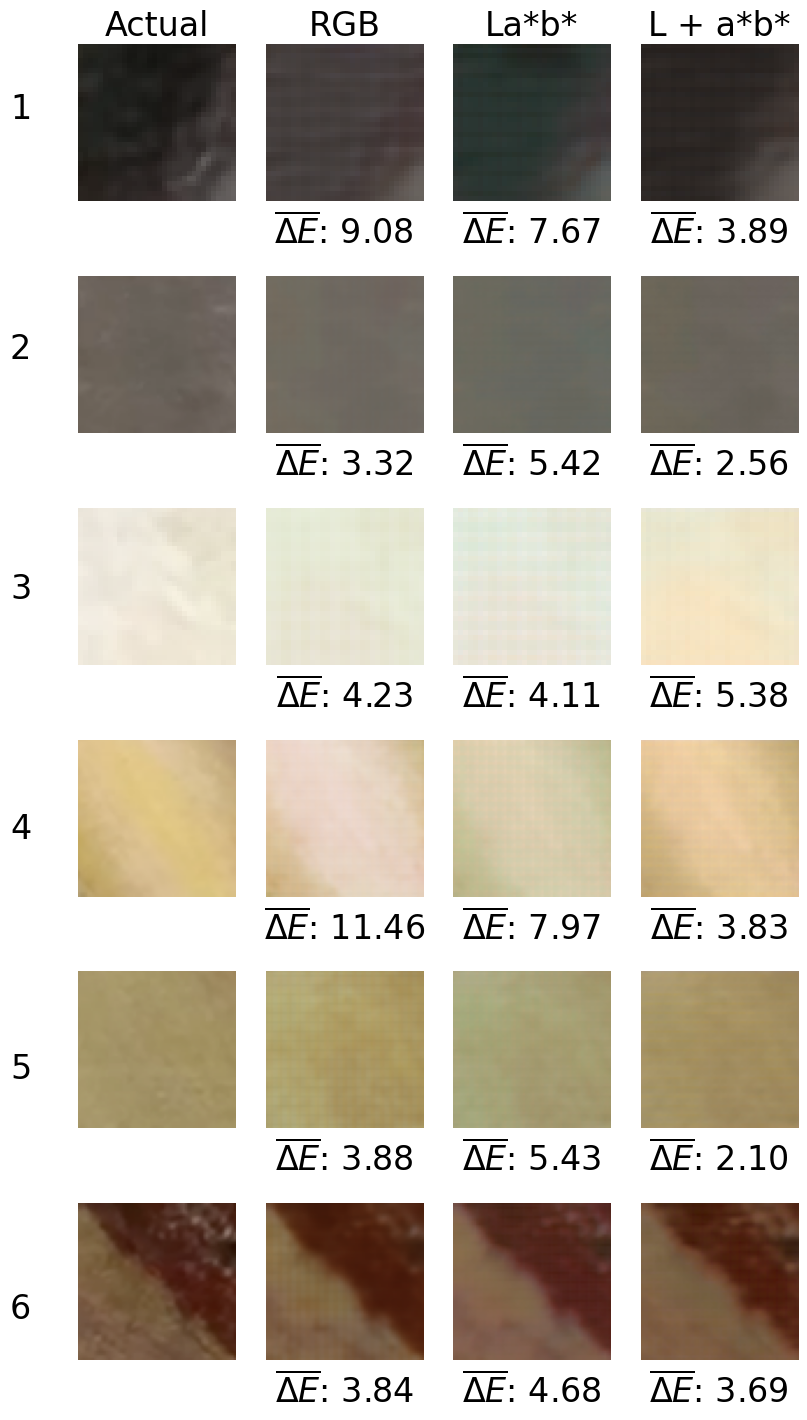

In [24]:
# Compute maximum delta E for scaling the bars
max_delta_e = max(max(values) for values in delta_e_results)

# Plotting (ROTATED: models as columns, images as rows)
fig, axes = plt.subplots(num_images, num_rows, figsize=(2 * num_rows, 2.4 * num_images))  # Extra height for bar

if num_images == 1:
    axes = np.array([axes])

col_labels = ["Actual"] + [name for name, _ in model_folders]

for img_idx, filename in enumerate(image_filenames):
    for col_idx in range(num_rows):
        ax = axes[img_idx, col_idx]

        if col_idx == 0:
            img = io.imread(os.path.join(ground_truth_folder, filename))[2:-2, 2:-2]
        else:
            img = io.imread(os.path.join(model_folders[col_idx - 1][1], filename))[2:-2, 2:-2]

        ax.imshow(img)
        ax.axis('off')

        if img_idx == 0:
            ax.set_title(col_labels[col_idx], fontsize=24)

        if col_idx > 0:
            delta_e = delta_e_results[col_idx - 1][img_idx]

            # Add ΔE text
            ax.text(0.5, -0.08, r"$\overline{\Delta E}$" + f": {delta_e:.2f}",
                    fontsize=24, ha='center', va='top', transform=ax.transAxes)

# Add row labels (image names)
for img_idx, filename in enumerate(image_filenames):
    label = os.path.splitext(filename)[0]  # Removes .png, .jpg, etc.
    y = 1 - (img_idx + 0.5) / num_images
    fig.text(0.02, y, label, fontsize=24, va='center', ha='right')


plt.tight_layout(rect=[0.06, 0, 1, 1])  # Leave room for row labels
plt.show()


# Visualize delta E on whole painting

In [18]:
def delta_e_cie2000(lab1, lab2):
    # Constants
    kL = 1
    kC = 1
    kH = 1

    L1, a1, b1 = lab1
    L2, a2, b2 = lab2

    # CIE 2000 formula
    L_bar_prime = 0.5 * (L1 + L2)
    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    C_bar = 0.5 * (C1 + C2)
    C_bar7 = C_bar**7

    G = 0.5 * (1 - np.sqrt(C_bar7 / (C_bar7 + 25**7)))
    a1_prime = (1 + G) * a1
    a2_prime = (1 + G) * a2

    C1_prime = np.sqrt(a1_prime**2 + b1**2)
    C2_prime = np.sqrt(a2_prime**2 + b2**2)
    C_bar_prime = 0.5 * (C1_prime + C2_prime)

    h1_prime = np.degrees(np.arctan2(b1, a1_prime)) % 360
    h2_prime = np.degrees(np.arctan2(b2, a2_prime)) % 360

    H_bar_prime = h1_prime + h2_prime
    if abs(h1_prime - h2_prime) > 180:
        H_bar_prime += 360
    H_bar_prime *= 0.5

    T = 1 - 0.17 * np.cos(np.radians(H_bar_prime - 30)) \
        + 0.24 * np.cos(np.radians(2 * H_bar_prime)) \
        + 0.32 * np.cos(np.radians(3 * H_bar_prime + 6)) \
        - 0.20 * np.cos(np.radians(4 * H_bar_prime - 63))

    delta_h_prime = h2_prime - h1_prime
    if abs(delta_h_prime) > 180:
        if h2_prime <= h1_prime:
            delta_h_prime += 360
        else:
            delta_h_prime -= 360

    delta_L_prime = L2 - L1
    delta_C_prime = C2_prime - C1_prime
    delta_H_prime = 2 * np.sqrt(C1_prime * C2_prime) * np.sin(np.radians(delta_h_prime * 0.5))

    S_L = 1 + ((0.015 * (L_bar_prime - 50) ** 2) / np.sqrt(20 + (L_bar_prime - 50) ** 2))
    S_C = 1 + 0.045 * C_bar_prime
    S_H = 1 + 0.015 * C_bar_prime * T

    delta_theta = 30 * np.exp(-(((H_bar_prime - 275) / 25) ** 2))
    R_C = 2 * np.sqrt(C_bar7 / (C_bar7 + 25**7))
    R_T = -R_C * np.sin(2 * np.radians(delta_theta))

    delta_E = np.sqrt(
        (delta_L_prime / (kL * S_L)) ** 2 +
        (delta_C_prime / (kC * S_C)) ** 2 +
        (delta_H_prime / (kH * S_H)) ** 2 +
        R_T * (delta_C_prime / (kC * S_C)) * (delta_H_prime / (kH * S_H))
    )

    return delta_E

def color_error(image1_path,image2_path):
    image1 = io.imread(image1_path)
    image2 = io.imread(image2_path)
    # Ensure images are in uint8 format
    if image1.dtype != np.uint8:
        image1 = (image1 * 255).astype(np.uint8)
    if image2.dtype != np.uint8:
        image2 = (image2 * 255).astype(np.uint8)
    # Remove the alpha channel if it exists
    if image1.shape[-1] == 4:
        image1 = image1[..., :3]
    if image2.shape[-1] == 4:
        image2 = image2[..., :3]
    # Ensure the images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")
    # Convert images to LAB color space
    image1_lab = cv2.cvtColor(image1, cv2.COLOR_RGB2LAB)
    image2_lab = cv2.cvtColor(image2, cv2.COLOR_RGB2LAB)

    # Scale LAB values to match theoretical ranges
    image1_lab = np.copy(image1_lab).astype(np.float64)
    image2_lab = np.copy(image2_lab).astype(np.float64)

    image1_lab[:, :, 0] = image1_lab[:, :, 0] * (100 / 255)  # L channel
    image1_lab[:, :, 1] = image1_lab[:, :, 1] - 128          # a channel
    image1_lab[:, :, 2] = image1_lab[:, :, 2] - 128          # b channel

    image2_lab[:, :, 0] = image2_lab[:, :, 0] * (100 / 255)  # L channel
    image2_lab[:, :, 1] = image2_lab[:, :, 1] - 128          # a channel
    image2_lab[:, :, 2] = image2_lab[:, :, 2] - 128          # b channel

    # Flatten the images for easier processing
    image1_lab_flat = image1_lab.reshape((-1, 3))
    image2_lab_flat = image2_lab.reshape((-1, 3))

    # Compute Delta E 2000 for each pair of pixels
    delta_e_values = np.array([delta_e_cie2000(lab1, lab2) for lab1, lab2 in zip(image1_lab_flat, image2_lab_flat)])
    delta_e_values_mean = np.mean(delta_e_values)
    # Reshape the delta_e_values to match the image dimensions, if u wanna plot
    delta_e_image = delta_e_values.reshape(image1_lab.shape[:2])
    return delta_e_image,delta_e_values_mean

In [ ]:
gt_path = file_path+"Paintings/test/[24-After]_test.png"
out_path = file_path+"Paintings/test/[24-Before]_l_ab.png"
delta_E, delta_e_values_mean = color_error(gt_path,out_path)
print(delta_e_values_mean)
plt.imshow(delta_E)
plt.colorbar()
plt.axis('off')